# Notebook to make gif 1: time evolution of fig 1

In [0]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
from scipy.stats import gaussian_kde
import importlib
import imageio

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D

import seaborn as sns
cp = sns.color_palette('muted')
cp2 = sns.color_palette('pastel')

import sys
sys.path.append('../utils')
import reconstructwf as rwf

sys.path.append('../scripts')
from helper_functions import *

style.use('plotting.mplstyle')

import warnings
warnings.filterwarnings("ignore", module="matplotlib")

data_dir = '../data/' 

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


### Load in data: posteriors

Load in posterior and prior samples

In [1]:
td_samples, tcutoffs = load_posterior_samples(data_dir)

Generate KDE for $\chi_\mathrm{p}$ from the full run and the prior, for comparison 

In [2]:
# kde for full run 
samples_full = td_samples['full']
m1_full, m2_full = m1m2_from_mtotq(samples_full['mtotal'], samples_full['q'])
chip_full_samples = chi_precessing(m1_full, samples_full['chi1'], samples_full['tilt1'],
                          m2_full, samples_full['chi2'], samples_full['tilt2'])

chip_grid, chip_full_kde_on_grid = reflected_kde(chip_full_samples, 0, 1)

# kde for prior 
samples_prior = td_samples['prior']
m1_prior, m2_prior = m1m2_from_mtotq(samples_prior['mtotal'], samples_prior['q'])
chip_prior_samples = chi_precessing(m1_prior, samples_prior['chi1'], samples_prior['tilt1'],
                          m2_prior, samples_prior['chi2'], samples_prior['tilt2'])

_, chip_prior_kde_on_grid = reflected_kde(chip_prior_samples, 0, 1)

### Load in data: strain timeseries

Load in time-domain data from the detectors

In [3]:
data_dict =  np.load(data_dir+'LVC_strain_data.npy', allow_pickle=True).item()
wh_data_dict =  np.load(data_dir+'LVC_strain_data_whitened.npy', allow_pickle=True).item()
time_dict_data =  np.load(data_dir+'LVC_time_data.npy', allow_pickle=True).item()

Load in reconstructions from before/after each cutoff time

In [4]:
reconstruction_dict_all = np.load(data_dir+"waveform_reconstructions_all_detectors.npy", allow_pickle=True).item()
reconstruction_dict = {k:reconstruction_dict_all[k]['L1'] for k in reconstruction_dict_all.keys()}

Define cutoff times 

In [5]:
# 0M <-> seconds
t0_0M_dict = {}
t0_0M_geo = 1242442967.405764
dt_10M = 0.0127 # 10 M = 12.7 ms 
dt_1M = dt_10M/10.

tstart = 1242442966.9077148
tend = 1242442967.607715
ra = 6.07546535866838
dec = -0.8000357325337637

# define t_0M in each detector in seconds
for ifo in ['H1', 'L1', 'V1']: 
    
    t_delay = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix[ifo].location, ra, dec, t0_0M_geo)
    t0_0M_dict[ifo] = t0_0M_geo + t_delay
    
# Max p strain from full run
lnP = reconstruction_dict['full']['params']['ln_posterior']
i_maxP = np.argmax(lnP)
L1_maxP_strain = np.asarray(reconstruction_dict['full']['h'][i_maxP])
L1_maxP_strain_wh = np.asarray(reconstruction_dict['full']['wh'][i_maxP])

# L1 strain
L1_LVC_strain = data_dict['L1']
L1_LVC_strain_wh = wh_data_dict['L1']

# Transform timeseries into into units of M
reconstruction_times_M = (reconstruction_dict['time samples']- t0_0M_dict['L1'])/dt_1M
L1_times_M = (time_dict_data['L1'] - t0_0M_dict['L1'])/dt_1M

### Make gif

In [6]:
# Plot all times
tc_to_plot = tcutoffs
n_to_plot = len(tc_to_plot)

# Cast strings to floats
tc_floats = []
for tc_str in tc_to_plot:
    if tc_str[0]=='m':
        tc_str_trimmed = tc_str[1:-1]
    else:
        tc_str_trimmed = tc_str[0:-1]     
    tc_float = -1*float(tc_str_trimmed) if tc_str[0]=='m' else float(tc_str_trimmed) 
    tc_floats.append(tc_float)
    
print(tc_floats)

[-50.0, -40.0, -37.5, -35.0, -32.5, -30.0, -27.5, -25.0, -22.5, -20.0, -17.5, -15.0, -12.5, -10.0, -7.5, -5.0, -2.5, 0.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0, 30.0, 40.0, 50.0]


m50M


/var/folders/w7/r9xkmg4d7n18hlq715yknq9w0000gq/T/ipykernel_31577/411611844.py:115: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(['0', '0.25', '0.5', '0.75', '1'])


m40M
m37.5M
m35M
m32.5M
m30M
m27.5M
m25M
m22.5M
m20M
m17.5M
m15M
m12.5M
m10M
m7.5M
m5M
m2.5M
0M
2.5M
5M
7.5M
10M
12.5M
15M
17.5M


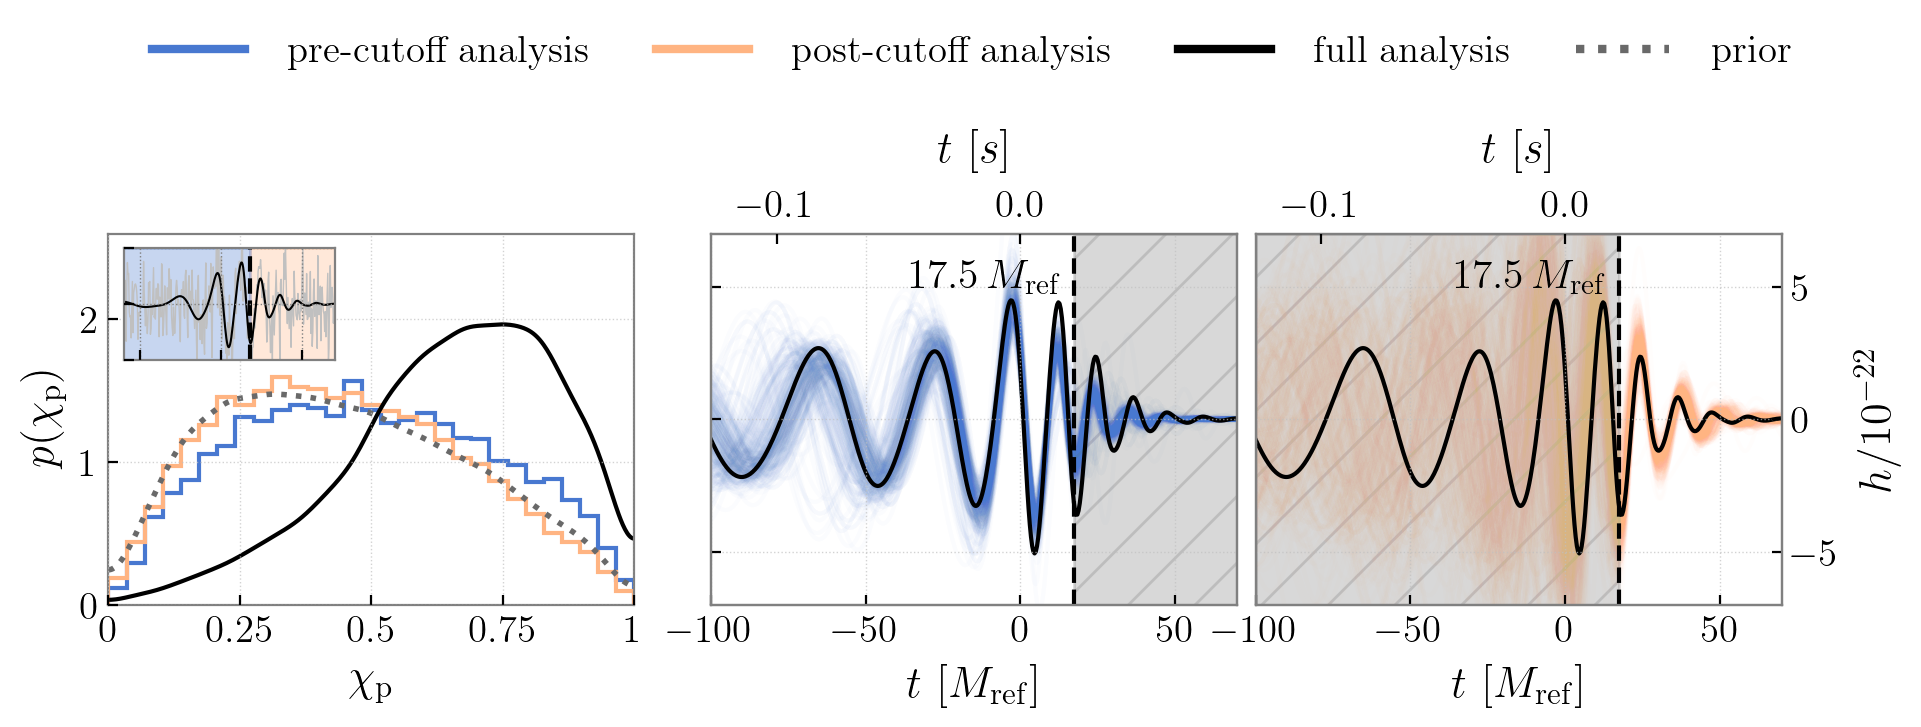

20M
30M
40M
50M


In [7]:
# Cycle through times
for j,tc in enumerate(tc_floats):  
        
    # Make figure 
    fig, axes = plt.subplots(1, 3, figsize=(15/1.3, 25/8/1.3))

    for ax in axes:
        ax.set_rasterization_zorder(2)
    
    # String for labeling the time step
    tc_str = tc_to_plot[j]
    lbl = tc_str.replace('m', '-') if tc_str[0]=='m' else tc_str
    lbl = lbl.replace('M', '\,M_\mathrm{ref}')
    
    print(tc_str)
    
    # Middle plots: bandpassed waveforms with cutoff
    x_lims = [-100, 70]
    
    for k in [1,2]:
        
        top_ax = axes[k].twiny()
        top_ax.plot(L1_times_M*dt_1M, L1_LVC_strain/(1e-22), color='k', alpha=0, zorder=3)
        top_ax.set_xlabel(r'$t~[s] $', fontsize=16, labelpad=10)
        top_ax.set_xlim(x_lims[0]*dt_1M, x_lims[1]*dt_1M)
        top_ax.grid(visible=False)

        axes[k].plot(L1_times_M, L1_LVC_strain/(1e-22), color='k', alpha=0, zorder=3)
            
        axes[k].plot(reconstruction_times_M, L1_maxP_strain/(1e-22), color='k')
        axes[k].axvline(tc, ls='--', color='k', zorder=4)

        axes[k].set_xlabel(r'$t~[M_\mathrm{ref}]$', fontsize=16)

        # Plot reconstructions before/after the cutoff
        n_reconstruction_to_plot = 300
        alpha_reconstruct = 0.02
        shading_kws = dict(hatch='/',  alpha=0.3, color='gray')
        if k==1:
            try:
                reconstructions = np.asarray(reconstruction_dict[f'insp {tc_str}']['h'])
            except: 
                reconstructions = np.asarray(reconstruction_dict['prior']['h'])
                
            idxs_to_plot = np.random.choice(reconstructions.shape[0], size=n_reconstruction_to_plot)
            axes[k].plot(reconstruction_times_M, np.transpose(reconstructions[idxs_to_plot,:])/(1e-22), 
                            color=cp[0], alpha=alpha_reconstruct, zorder=1)
            
            axes[k].axvspan(tc, x_lims[-1], **shading_kws, zorder=0)

        else:
            reconstructions = np.asarray(reconstruction_dict[f'rd {tc_str}']['h'])
            
            idxs_to_plot = np.random.choice(reconstructions.shape[0], size=n_reconstruction_to_plot)
            axes[k].plot(reconstruction_times_M, np.transpose(reconstructions[idxs_to_plot,:])/(1e-22), 
                            color=cp2[1], alpha=alpha_reconstruct, zorder=1)
            
            axes[k].axvspan(x_lims[0], tc, **shading_kws, zorder=0)

        axes[k].grid(color='silver', ls=':', alpha=0.7)
        axes[k].set_xlim(*x_lims)
        axes[k].set_ylim(-7, 7)
        
        # Add label for cutoff time
        if tc >= 20: 
            textloc = tc - 43
        elif tc == 17.5: 
            textloc = tc - 53
        else:
            textloc = tc + 4
        axes[k].text(textloc, 5, f'${lbl}$', color='k', fontsize=15, zorder=5)

    axes[2].yaxis.set_label_position("right")
    axes[2].yaxis.tick_right()
    axes[2].set_ylabel(r'$h/10^{-22}$', fontsize=16)
    axes[1].set_yticklabels([])
    
    
    dx = -0.05
    x0, y0, x1, y1 = axes[1].get_position().bounds
    axes[1].set_position([x0+dx+0.0375, y0, x1, y1])
    x0, y0, x1, y1 = axes[2].get_position().bounds
    axes[2].set_position([x0+dx, y0, x1, y1])
    
    # Righthand plots: chi_p posteriors
    try:
        samples_insp = td_samples[f'insp {tc_str}']
        m1_insp, m2_insp = m1m2_from_mtotq(samples_insp['mtotal'], samples_insp['q'])
        chip_insp = chi_precessing(m1_insp, samples_insp['chi1'], samples_insp['tilt1'], 
                                   m2_insp, samples_insp['chi2'], samples_insp['tilt2'])
    except: 
        samples_insp = td_samples['prior']
        mask = np.random.choice(len(samples_insp), size=len(td_samples[f'rd {tc_str}']))
        m1_insp, m2_insp = m1m2_from_mtotq(samples_insp['mtotal'][mask], samples_insp['q'][mask])
        chip_insp = chi_precessing(m1_insp, samples_insp['chi1'][mask], samples_insp['tilt1'][mask], 
                                   m2_insp, samples_insp['chi2'][mask], samples_insp['tilt2'][mask])
    
    samples_rd = td_samples[f'rd {tc_str}']
    m1_rd, m2_rd = m1m2_from_mtotq(samples_rd['mtotal'], samples_rd['q'])
    chip_rd = chi_precessing(m1_rd, samples_rd['chi1'], samples_rd['tilt1'],
                                m2_rd, samples_rd['chi2'], samples_rd['tilt2'])
    
    axes[0].hist(chip_insp, histtype='step', bins=np.linspace(0,1,30), lw=1.5, 
                    color=cp[0], density=True)
    axes[0].hist(chip_rd, histtype='step', bins=np.linspace(0,1,30), lw=1.5, 
                    color=cp2[1], density=True)
    
    axes[0].plot(chip_grid, chip_full_kde_on_grid, color='k')
    prior_kws = dict(color='dimgray', ls=':')
    axes[0].plot(chip_grid, chip_prior_kde_on_grid, **prior_kws, lw=2)
    
    axes[0].set_ylabel(r'$p(\chi_\mathrm{p})$', fontsize=16)

    axes[0].set_xlabel(r'$\chi_\mathrm{p}$', fontsize=16)
    axes[0].set_xticklabels(['0', '0.25', '0.5', '0.75', '1'])
    axes[0].set_xlim(0,1)
    axes[0].set_ylim(0,2.6)
    axes[0].grid(color='silver', ls=':', alpha=0.7)

    
    # Inset axis in leftmost column with whitened strain
    l = 0.4
    w = 0.3
    dx = 0.04
    axin = axes[0].inset_axes([dx-0.01, 1-dx-w, l, w])
    axin.plot(L1_times_M, L1_LVC_strain_wh, color='silver', lw=0.5)
    axin.plot(reconstruction_times_M, L1_maxP_strain_wh, color='k', lw=0.75)
    axin.axvline(tc, ls='--', color='k')
    axin.axvspan(tc, x_lims[-1], color=cp2[1], alpha=0.3, zorder=0)
    axin.axvspan(x_lims[0], tc, color=cp[0], alpha=0.3, zorder=0)
    axin.set_xlim(-60, 70)
    axin.set_ylim(-2.5, 2.5)
    axin.set_xticklabels([])
    axin.set_yticklabels([])
    
    for ax in axes: 
        x0, y0, x1, y1 = ax.get_position().bounds
        ax.set_position([x0, y0, x1, y1+0.05/n_to_plot])

    # Legend
    handles = [
        Line2D([], [], color=cp[0], label='pre-cutoff analysis'),
        Line2D([], [], color=cp2[1], label='post-cutoff analysis'),
        Line2D([], [], color='k', label='full analysis'),
        Line2D([], [], **prior_kws, label='prior')
    ]
    leg = axes[2].legend(
        handles=handles, 
        bbox_to_anchor=(-2.15, 1.4, 3.2, .102), loc='lower left', ncols=4, 
        mode="expand", borderaxespad=0., frameon=False, fontsize=14, handlelength=3
    )
    for i, h in enumerate(handles):
        leg.get_lines()[i].set_linewidth(3)

    plt.savefig(f'for_gif_01/frame_{tc_str}.png',bbox_inches='tight',dpi=200)
    
    if j==24:
        plt.show()
    else:
        plt.close()

In [8]:
# Assemble into a gif
frames = []
for tc in tcutoffs:
    image = imageio.v2.imread(f'for_gif_01/frame_{tc}.png')
    frames.append(image)
fps = 1.5
imageio.mimsave('gif_01.gif', frames, fps=fps)  